In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.collections import LineCollection

import matplotlib.colors as colors

In [2]:
from tphenotype import LaplaceEncoder, Predictor
from tphenotype.baselines import E2P, KME2P, KMDTW
from tphenotype.utils import get_auc_scores, get_cls_scores, select_by_steps, get_one_hot, data_split
from tphenotype.utils.dataset import cut_windowed_data

import sys
import os
import pickle
sys.path.append('../benchmark')
from benchmark import KME2P_config, Predictor_config, Encoder_config, Cls_config, loss_weights
from numpy.core.multiarray import interp

def batch_interp(t, tp, fp):
    f = []
    for i in range(fp.shape[0]):
        tp_i = tp[i]
        fp_i = fp[i]
        m = np.isnan(fp_i)
        f.append(interp(t, tp_i[~m], fp_i[~m]))
    
    f = np.stack(f, axis=0)
    return f

In [4]:
dataname = 'ICU'
with open(f'../benchmark/data/{dataname}_data.pkl', 'rb') as file:
    splits = pickle.load(file)

data_idx = 0
print(dataname)
train_set,valid_set,test_set = splits[data_idx]
print(f"total samples: {len(train_set['x'])+len(valid_set['x'])+len(test_set['x'])}")
_, T, x_dim = train_set['x'].shape
_, _, y_dim = train_set['y'].shape
print(f'max length: {T}')
print(f'x_dim: {x_dim}')
print(f'y_dim: {y_dim}')

feat_list = ['Age', 'Gender', 'GCS', 'PaCO2']
temporal_dims = [2, 3]


print(f'features: {feat_list}')
print(f'temporal dims: {temporal_dims}')


ICU
total samples: 1554
max length: 24
x_dim: 4
y_dim: 2
features: ['Age', 'Gender', 'GCS', 'PaCO2']
temporal dims: [2, 3]


In [7]:
K=3

KME2P_y_config = KME2P_config.copy()
KME2P_y_config['K'] = K
KME2P_y_config['x_dim'] = x_dim
KME2P_y_config['y_dim'] = y_dim
KME2P_y_config['latent_space'] = 'y'
KME2P_y_config['num_layers'] = 4
KME2P_y_config['hidden_size'] = 5

KME2P_z_config = KME2P_y_config.copy()
KME2P_z_config['latent_space'] = 'z'
KME2P_y_config['num_layers'] = 3
KME2P_y_config['hidden_size'] = 30
KME2P_y_config['latent_size'] = 5

KMDTW_config = {'K':K}

encoder_config = Encoder_config.copy()
encoder_config['pole_separation']=1.5
encoder_config['max_degree']=2

cls_config = Cls_config.copy()
cls_config['K'] = K
cls_config['steps'] = [-1]
predictor_config = Predictor_config.copy()
predictor_config['x_dim'] = x_dim
predictor_config['y_dim'] = y_dim
predictor_config['time_series_dims'] = temporal_dims
predictor_config['cls_config'] = cls_config
predictor_config['encoder_config'] = encoder_config
predictor_config['num_layer'] = 2
predictor_config['hidden_size'] = 20

loss_weights = {
    'ce': 1.0,
    'rmse': 1.0,
    'cont':0.01,
    'pole': 1.0,
    'real': 0.1
}
# for experiment results in paper, seed=13
seed=13

In [8]:
seed=0
torch.random.manual_seed(seed)
TPhenotype = Predictor(**predictor_config)
TPhenotype = TPhenotype.fit(train_set, loss_weights,valid_set=valid_set,epochs=30, tolerance=None)

stage 1 - fit the Laplace Encoder 1/2


  0%|          | 0/30 [00:00<?, ?it/s]

stage 1 - fit the Laplace Encoder 2/2


  0%|          | 0/30 [00:00<?, ?it/s]

stage 2 - fit the predictor


  0%|          | 0/30 [00:00<?, ?it/s]

stage 3 - clustering on similarity graph
construct similarity graph


  0%|          | 0/462 [00:00<?, ?it/s]

discover clusters from similarity graph
done


In [9]:
y=test_set['y']
x=test_set['x']
x_orig=test_set['x_orig'][:,:,[0,1,3,4]]
mask=test_set['mask']
range_mask = test_set['range_mask']
t=test_set['t']
y_true=np.argmax(y, axis=-1)
y_true = select_by_steps(y_true, mask,steps=[-1])
c_label = TPhenotype.predict_cluster(x,t,mask,steps=[-1])

In [10]:
feat_list = np.array(feat_list)

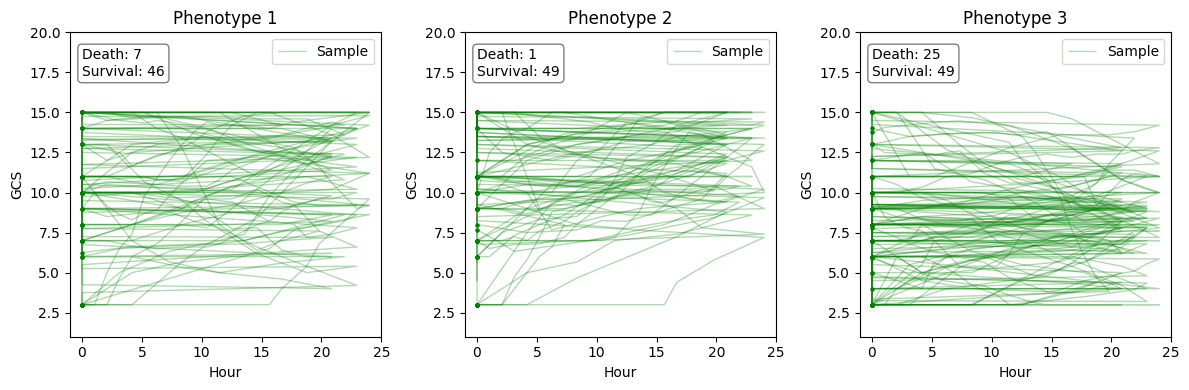

In [11]:
variable_name = 'GCS'
[idx], = np.where(feat_list==variable_name)
f = x_orig[:,:,idx].copy()
t_max = np.max(t, axis=-1, keepdims=True)
t_sync = t - t_max + np.max(t_max)
mask = range_mask

y_min, y_max = 1.2*np.min(f),1.2*np.max(f)
#y_min, y_max = -6,6
#f = f/(f.max(axis=-1,keepdims=True)+1e-10)
f[mask==0] = np.nan
t_scale=24
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(4*3,4))
for i,c in enumerate(range(K)):
    ax = axs[i]
    idx, = np.where(c_label==c)
    death = (y_true[idx]==1)
    
    
    t1 = t[idx]*t_scale
    x1 = f[idx]
    
    df=pd.DataFrame(x1)
    x1 = df.rolling(5,axis=1,min_periods=1).mean()
    constant = x1.std(axis=1)<1
    constant = constant.values
    x1 = x1.values
    t1 = t1[~constant]
    x1 = x1[~constant]
    death =death[~constant]
    num_death = death.sum()
    
    text = f'Death: {num_death:d}\nSurvival: {len(death)-num_death:d}'
    ax.text(0,19,text,va='top',ha='left',bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round'))
    
    line_segments = LineCollection([np.column_stack([ti, xi]) for ti,xi in zip(t1,x1)],color='green',alpha=0.3, linewidth=1,label='Sample')
    ax.add_collection(line_segments)

    ax.scatter((t1)[:,0], x1[:,0], marker='o',color='green',s=5)
    #t_interp = np.linspace(-0.0*t_scale,0.9*t_scale,num=100)
    #x1_interp = batch_interp(t_interp,t1,x1)
    #x1_mean= np.mean(x1_interp,axis=0)
    #ax.plot(t_interp, x1_mean, color='red', linestyle='dashed',linewidth=2, label='Mean')
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([-1, 25])
    ax.set_ylim([1,20])
    ax.set_ylabel(variable_name)
    ax.set_xlabel('Hour')
    ax.set_title(f'Phenotype {c+1}')
    ax.legend()
fig.tight_layout()
os.makedirs('figures', exist_ok=True)
fig.savefig('figures/Physionet-nonstable.pdf')

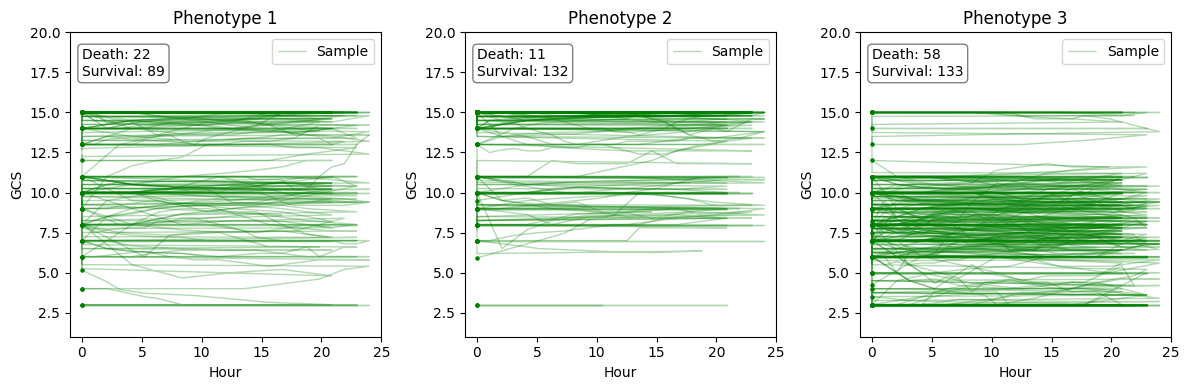

In [12]:
variable_name = 'GCS'
[idx], = np.where(feat_list==variable_name)
f = x_orig[:,:,idx].copy()
t_max = np.max(t, axis=-1, keepdims=True)
t_sync = t - t_max + np.max(t_max)
mask = range_mask

y_min, y_max = 1.2*np.min(f),1.2*np.max(f)
#y_min, y_max = -6,6
#f = f/(f.max(axis=-1,keepdims=True)+1e-10)
f[mask==0] = np.nan
t_scale=24
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(4*3,4))
for i,c in enumerate(range(K)):
    ax = axs[i]
    idx, = np.where(c_label==c)
    death = (y_true[idx]==1)
    
    text = f'Death: {num_death:d}\nSurvival: {len(idx)-num_death:d}'

    
    t1 = t[idx]*t_scale
    x1 = f[idx]
    
    df=pd.DataFrame(x1)
    x1 = df.rolling(5,axis=1,min_periods=1).mean()
    constant = x1.std(axis=1)<1
    constant = constant.values
    x1 = x1.values
    t1 = t1[constant]
    x1 = x1[constant]
    death =death[constant]
    num_death = death.sum()
    
    text = f'Death: {num_death:d}\nSurvival: {len(death)-num_death:d}'
    ax.text(0,19,text,va='top',ha='left',bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round'))
    
    line_segments = LineCollection([np.column_stack([ti, xi]) for ti,xi in zip(t1,x1)],color='green',alpha=0.3, linewidth=1,label='Sample')
    ax.add_collection(line_segments)

    ax.scatter((t1)[:,0], x1[:,0], marker='o',color='green',s=5)
    #t_interp = np.linspace(-0.0*t_scale,0.9*t_scale,num=100)
    #x1_interp = batch_interp(t_interp,t1,x1)
    #x1_mean= np.mean(x1_interp,axis=0)
    #ax.plot(t_interp, x1_mean, color='red', linestyle='dashed',linewidth=2, label='Mean')
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([-1, 25])
    ax.set_ylim([1,20])
    ax.set_ylabel(variable_name)
    ax.set_xlabel('Hour')
    ax.set_title(f'Phenotype {c+1}')
    ax.legend()
fig.tight_layout()
os.makedirs('figures', exist_ok=True)
fig.savefig('figures/Physionet-stable.pdf')